In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [ ]:
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)

,description,medical_specialty,sample_name,transcription,keywords
0,Cerebral Angiogram - moyamoya disease.,Neurology,Moyamoya Disease,"CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a ""flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found ""passed out"" in bed, and when awoken appeared ...","neurology, ct brain, mri, moya moya, mci, brain, brainstem, brain hemorrhoids, cerebral angiogram, cerebral, cct, mets, moy moya disease, lacunar infarct, caudate nucleus, mcystectomy, mary, mact, mue, monia, momy, mca, brain and brain, cpt, mct,"
1,Blood in urine - Transitional cell cancer of the bladder.,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,","cardiovascular / pulmonary, progress note, chest pain, respiratory insufficiency, acuities, ventricular wall motion study at rest, laparoscopic cholecystectomy, endotracheal intubated spect, accuities, stapler at rest and without contrast, acudal posi..."
2,"This is a 66-year-old male with signs and symptoms of benign prostatic hypertrophy, who has had recurrent urinary retention since his kidney transplant. He passed his fill and pull study and was thought to self-catheterize in the event that he does i...",Urology,Urinary Retention,"CHIEF COMPLAINT:, Urinary retention.,HISTORY OF PRESENT ILLNESS: , This is a 66-year-old gentleman status post deceased donor kidney transplant in 12/07, who has had recurrent urinary retention issues since that time. Most recently, he was hospitali...","urology, urinary retention issues, cystoscopy, nephrolithiasis, kidney transplant, renal insufficiency, renal disease, renal retention, renal failure, renal transplant, kidney cancer, renal, bladder, bladder and spleen, bladder neck fistula placements..."


All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4999 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [ ]:
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count
0,Surgery,526754
1,Consult - History and Phy.,287961
2,Orthopedic,198489
3,Cardiovascular / Pulmonary,160867
4,General Medicine,120978
5,Neurology,110677
6,Gastroenterology,80347
7,Radiology,74969
8,Obstetrics / Gynecology,72589
9,Urology,63419


In [ ]:
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)

Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

In [ ]:
# import pandas as pd

# # Assuming 'medical_specialty' is the name of your column with 40 classes
# groups = {
#     "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
#     "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
#     "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
#     "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
#     "Other Specialties": []  # remaining specialties
# }

# # Create a mapping dictionary
# class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# # Replace the original 'medical_specialty' column
# df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)


In [ ]:

df["medical_specialty"].value_counts()

Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

In [ ]:
# import pandas as pd

# # Assuming 'class_column' is the name of your column with 40 classes
# df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')


In [ ]:
cause_dist = df['medical_specialty'].value_counts()[1:20]
print(cause_dist)

Consult - History and Phy.       516
Cardiovascular / Pulmonary       372
Orthopedic                       355
Radiology                        273
General Medicine                 259
Gastroenterology                 230
Neurology                        223
SOAP / Chart / Progress Notes    166
Obstetrics / Gynecology          160
Urology                          158
Discharge Summary                108
ENT - Otolaryngology              98
Neurosurgery                      94
Hematology - Oncology             90
Ophthalmology                     83
Nephrology                        81
Emergency Room Reports            75
Pediatrics - Neonatal             70
Pain Management                   62
Name: medical_specialty, dtype: int64


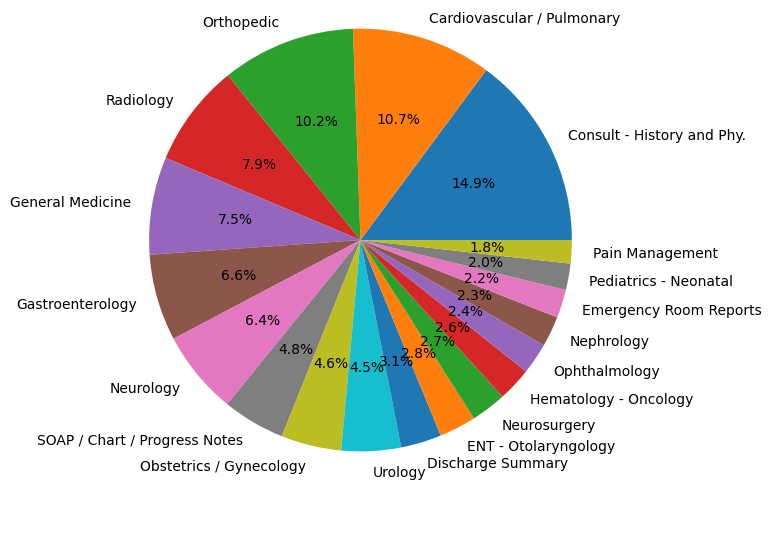

In [ ]:
plt.figure(figsize=(6,6))
plt.title(' ', y=-0.15)
plt.pie(cause_dist, labels=list(cause_dist.index), autopct="%.1f%%")
plt.axis('equal');

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4999 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [ ]:
df["medical_specialty"].value_counts()

Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4999 non-null   object
dtypes: object(5)
memory usage: 234.3+ KB


In [ ]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           4966 non-null   object
dtypes: object(5)
memory usage: 232.8+ KB


In [ ]:
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))

Text with the minimum word count (1 words):
INDICATIONS:,

Text with the maximum word count (3029 words):
DATE OF INJURY : October 4, 2000,DATE OF EXAMINATION : September 5, 2003,EXAMINING PHYSICIAN : X Y, MD,Prior to the beginning of the examination, it is explained to the examinee that this examination is intended for evaluative purposes only, and that it is not intended to constitute a general medical examination. It is explained to the examinee that the traditional doctor-patient relationship does not apply to this examination, and that a written report will be provided to the agency requesting this examination. It has also been emphasized to the examinee that he should not attempt any physical activity beyond his tolerance, in order to avoid injury.,CHIEF COMPLAINT:  ,Aching and mid back pain.,HISTORY OF PRESENT INJURY: , Based upon the examinee's perspective: ,Mr. Abc is a 52-year-old self-employed, independent consultant for DEMILEE-USA. He is also a mechanical engineer. He repo

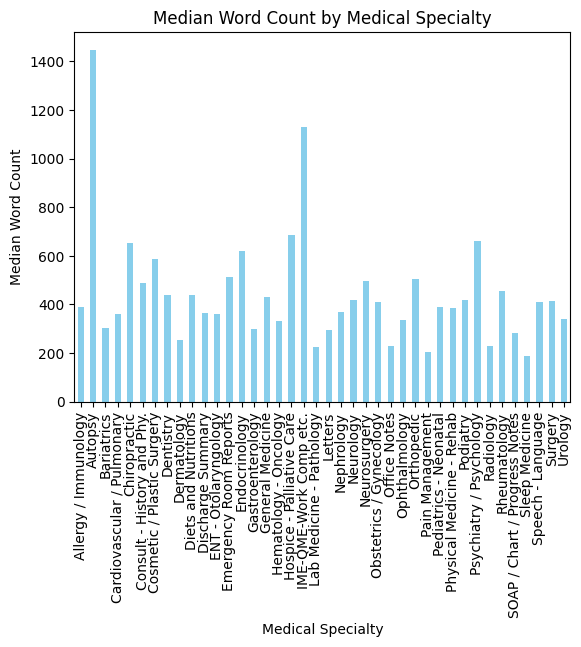

In [ ]:
import matplotlib.pyplot as plt

# Add a new column 'word_count' to store the word count for each row
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Calculate the median word count for each category
average_word_count_by_category = df.groupby('medical_specialty')['word_count'].median()

# Plotting the bar chart
average_word_count_by_category.plot(kind='bar', color='skyblue')
plt.title('Median Word Count by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Median Word Count')
plt.show()

In [ ]:
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):


    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['keywords']+df['transcription']
    # df['transcription'] = df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



['.config', 'data.csv', 'sample_data']
                                                                                                                                                                                                                                                      description  \
0                                                                                                                                                                                                                          Cerebral Angiogram - moyamoya disease.   
1                                                                                                                                                                                                       Blood in urine - Transitional cell cancer of the bladder.   
2  This is a 66-year-old male with signs and symptoms of benign prostatic hypertrophy, who has had recurrent urinary retention since his kidney transplant.  He passed his fill an

AttributeError: 'CustomRobertaForClassification' object has no attribute 'train_model'

In [ ]:
!pip install simpletransformers
import pandas as pd
import os, sys
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch
import sklearn
from transformers import RobertaModel, RobertaConfig
from torch import nn

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual, pred)
    f1_sc = f1_score(actual, pred, average="micro")
    return bal_acc, f1_sc

from sklearn.utils import class_weight

def data_loader(df, batch_size=8):  # Specify the batch size as needed
    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(), list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x: class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['keywords'] + df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]

    train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)

    # Compute class weights using sklearn's class_weight
    class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(train_y), y=train_y['medical_specialty'])
    class_weights = dict(zip(np.unique(train_y), class_weights))

    print(df.head())

    # Convert train and test data to PyTorch tensors
    train_inputs = torch.tensor(train_x['transcription'].astype('str').values)  # Convert to string type
    train_labels = torch.tensor(train_y['medical_specialty'].values)
    test_inputs = torch.tensor(test_x['transcription'].astype('str').values)  # Convert to string type
    test_labels = torch.tensor(test_y['medical_specialty'].values)

    # Create DataLoader
    train_dataset = TensorDataset(train_inputs, train_labels)
    test_dataset = TensorDataset(test_inputs, test_labels)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader, num_classes, class_weights, class_dict

# Usage
train_dataloader, test_dataloader, num_classes, class_weights, class_dict = data_loader(df)


class CustomRobertaForClassification(nn.Module):
    def __init__(self, config, num_labels, additional_hidden_layers):
        super(CustomRobertaForClassification, self).__init__()
        self.roberta = RobertaModel(config)
        self.additional_layers = nn.ModuleList([
            nn.Linear(additional_hidden_layers[i - 1], additional_hidden_layers[i])
            for i in range(1, len(additional_hidden_layers))
        ])
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(additional_hidden_layers[-1], num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs.pooler_output
        for layer in self.additional_layers:
            pooled_output = layer(pooled_output)
            pooled_output = nn.ReLU()(pooled_output)
            pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

if __name__ == '__main__':
    train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text', 'labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())

    test_df = pd.DataFrame(columns=['text', 'labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']

    learning_rate = 1e-5
    num_of_epochs = 3

    # Instantiate your custom model
    config = RobertaConfig.from_pretrained("roberta-base")
    config.num_labels = num_classes
    additional_hidden_layers = [config.hidden_size, config.hidden_size // 2, num_classes]
    custom_model = CustomRobertaForClassification(config, num_labels=config.num_labels, additional_hidden_layers=additional_hidden_layers)

    # Specify the optimizer and learning rate scheduler
    optimizer = torch.optim.AdamW(custom_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    custom_model.to(device)

    # Training loop
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_of_epochs):
        custom_model.train()
        for batch in train_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = custom_model(inputs)
            loss = criterion(outputs[0], labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluation
        custom_model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = custom_model(inputs)
                # Calculate metrics and print results

    # Save your trained model if needed
    torch.save(custom_model.state_dict(), 'custom_model.pth')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'simpletransformers'

In [ ]:
from transformers import RobertaModel, RobertaConfig, RobertaTokenizer
from torch import nn
from torch.nn import CrossEntropyLoss

class CustomRobertaForClassification(nn.Module):
    def __init__(self, config, num_labels, additional_hidden_layers):
        super(CustomRobertaForClassification, self).__init__()
        self.roberta = RobertaModel(config)
        self.additional_layers = nn.ModuleList([
            nn.Linear(additional_hidden_layers[i - 1], additional_hidden_layers[i])
            for i in range(1, len(additional_hidden_layers))
        ])
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(additional_hidden_layers[-1], num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs.pooler_output
        for layer in self.additional_layers:
            pooled_output = layer(pooled_output)
            pooled_output = nn.ReLU()(pooled_output)
            pooled_output = self.dropout(pooled_output)

        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

# Define your model configuration
config = RobertaConfig.from_pretrained("roberta-base")
config.num_labels = 40  # Change this based on the number of classes in your dataset

# Specify the dimensions for the additional hidden layers
additional_hidden_layers = [config.hidden_size, config.hidden_size // 2, 128]  # Adjust as needed

# Instantiate your custom model
custom_model = CustomRobertaForClassification(config, num_labels=config.num_labels, additional_hidden_layers=additional_hidden_layers)


In [ ]:
df["medical_specialty"].value_counts()

2     1088
32     516
34     371
13     355
7      273
23     259
24     224
0      223
4      166
1      156
16     155
28     108
25      96
17      94
22      90
14      83
18      81
27      75
11      70
12      61
8       53
15      50
9       47
29      29
31      27
30      27
19      23
10      21
5       20
26      19
37      18
20      16
33      14
6       10
38      10
3        9
35       8
39       8
36       7
21       6
Name: medical_specialty, dtype: int64

with only transcription feature

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    # df['transcription'] = df['keywords']+df['transcription']
    # df['transcription'] = df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.23521496431199174 0.36956521739130427


with keywords and transcription

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    # df['transcription'] = df['keywords']+df['transcription']
    df['transcription'] = df["keywords"] +  df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8326205793669688 0.857487922705314


with transcription and keywrods

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    # df['transcription'] = df['keywords']+df['transcription']
    df['transcription'] = df['transcription'] + df["keywords"]

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.23353116504708846 0.3856682769726248


with description and transcription

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['description']+df['transcription']
    # df['transcription'] = df['transcription'] + df["keywords"]

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.240111180766313 0.37922705314009664


with sample_name and transcription

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['sample_name']+df['transcription']
    # df['transcription'] = df['transcription'] + df["keywords"]

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.2646779439266704 0.37922705314009664


with description, sample_name and transcription

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    # df['transcription'] = df['keywords']+df['transcription']
    df['transcription'] = df["description"] + df["sample_name"] + df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.2765647787110582 0.392109500805153


with keywords only

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    # df['transcription'] = df['keywords']+df['transcription']
    # df['transcription'] = df['transcription']

    X = df[['keywords']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['keywords']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['keywords']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8091214695325979 0.8405797101449275


bert base uncased

In [ ]:
import pandas as pd
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn
import torch

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual, pred)
    f1_sc = f1_score(actual, pred, average="micro")
    return bal_acc, f1_sc

def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['keywords']+df['transcription']
    # df['transcription'] = df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict

if __name__ == '__main__':
    train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text', 'labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text', 'labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']

    learning_rate = 1e-5
    num_of_epochs = 3

    # Update model_args for BERT
    model_args = ClassificationArgs(
        num_train_epochs=num_of_epochs,
        learning_rate=learning_rate,
        reprocess_input_data=True,
        save_model_every_epoch=False,
        overwrite_output_dir=True,
        train_batch_size=8,  # Adjust as needed based on your GPU memory
        eval_batch_size=8,
        max_seq_length=128,  # Adjust as needed based on your text length
    )

    # Use "bert-base-uncased" for BERT base uncased
    model = ClassificationModel(
        "bert",
        "bert-base-uncased",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
    )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)

    result, output = model.predict(test_df['text'].values.tolist())

    acc, f1 = eval_metrics(test_df['labels'], result)

    print(acc, f1)


['.config', 'data.csv', 'cache_dir', 'outputs', 'runs', 'sample_data']
2     1227
14     516
15     371
8      355
6      323
3      284
5      273
11     259
12     224
0      223
10     190
4      166
1      156
9      155
7      136
13     108
Name: medical_specialty, dtype: int64
                                                                                                                                                                                                                                                      description  \
0                                                                                                                                                                                                                          Cerebral Angiogram - moyamoya disease.   
1                                                                                                                                                                                                

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8126341300689617 0.8405797101449275


with traditional text pre-processing

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch


import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have already loaded the DataFrame 'df' and defined the 'data_loader' function

# Additional import for NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming (using Porter Stemmer)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the "transcription" column
df['transcription'] = df['transcription'].apply(preprocess_text)

# Additional TF-IDF vectorization (optional)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['transcription'])

# You can use X_tfidf as input for your model

# Continue with the rest of your code for data_loader, model training, and evaluation
print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual, pred)
    f1_sc = f1_score(actual, pred, average="micro")
    return bal_acc, f1_sc

def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    df['transcription'] = df['keywords']+df['transcription']
    # df['transcription'] = df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict

if __name__ == '__main__':
    train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text', 'labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text', 'labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']

    learning_rate = 1e-5
    num_of_epochs = 3

    # Update model_args for BERT
    model_args = ClassificationArgs(
        num_train_epochs=num_of_epochs,
        learning_rate=learning_rate,
        reprocess_input_data=True,
        save_model_every_epoch=False,
        overwrite_output_dir=True,
        train_batch_size=8,  # Adjust as needed based on your GPU memory
        eval_batch_size=8,
        max_seq_length=128,  # Adjust as needed based on your text length
    )

    # Use "bert-base-uncased" for BERT base uncased
    model = ClassificationModel(
        "bert",
        "bert-base-uncased",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
    )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)

    result, output = model.predict(test_df['text'].values.tolist())

    acc, f1 = eval_metrics(test_df['labels'], result)

    print(acc, f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['.config', 'data.csv', 'sample_data']
Surgery                          1227
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
 others                           323
others                            284
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
Internal Medicine                 190
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Emergency & Critical Care         136
Discharge Summary                 108
Name: medical_specialty, dtype: int64
                                                                                                                                                                                                                                                      description  \
0                                                     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8163564625518425 0.8325281803542672


In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    return df
pd.set_option('display.max_colwidth', 255)
df =pd.read_csv('/content/data.csv')
df = trim(df)

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

df.head(3)
medical_specialty_list = [] ; word_count_list =[]
for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    medical_specialty_list.append(medical_specialty)
    word_count_list.append(word_count_temp)
word_count_df = pd.DataFrame({'Medical Specialty':medical_specialty_list, 'Word Count':word_count_list})
word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)
word_count_df.reset_index(drop=True)
cause_dist = df['medical_specialty'].value_counts()
print(cause_dist)
import pandas as pd

# Assuming 'medical_specialty' is the name of your column with 40 classes
groups = {
    "Surgery": ["Neurosurgery", "Cosmetic / Plastic Surgery", "Bariatrics"],
    "Internal Medicine": ["Endocrinology", "Nephrology", "Hematology - Oncology"],
    "Emergency & Critical Care": ["Emergency Room Reports", "Pain Management"],
    "Rehab & Psychology": ["Psychiatry / Psychology", "Physical Medicine - Rehab"],
    "Other Specialties": []  # remaining specialties
}

# Create a mapping dictionary
class_mapping = {specialty: category for category, specialties in groups.items() for specialty in specialties}

# Replace the original 'medical_specialty' column
df['medical_specialty'] = df['medical_specialty'].replace(class_mapping)
import pandas as pd

# Assuming 'class_column' is the name of your column with 40 classes
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: x if df['medical_specialty'].value_counts()[x] >= 52 else 'others')

df.dropna(inplace = True)
df.info()
df['word_count'] = df['transcription'].apply(lambda x: len(str(x).split()))

# Find the row with the minimum word count
min_word_row = df.loc[df['word_count'].idxmin()]['transcription']
min_word_count = df['word_count'].min()

# Find the row with the maximum word count
max_word_row = df.loc[df['word_count'].idxmax()]['transcription']
max_word_count = df['word_count'].max()

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Display the results
print("Text with the minimum word count ({} words):".format(min_word_count))
print(min_word_row)

print("\nText with the maximum word count ({} words):".format(max_word_count))
print(max_word_row)

print("\nAverage word count across all rows: {:.2f} words".format(average_word_count))
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch


import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you have already loaded the DataFrame 'df' and defined the 'data_loader' function

# Additional import for NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming (using Porter Stemmer)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the "transcription" column
df['transcription'] = df['transcription'].apply(preprocess_text)

# Additional TF-IDF vectorization (optional)
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['transcription'])

print(os.listdir())

datapath = "data"

cuda_available = torch.cuda.is_available()

def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc


def data_loader(df):
    # df = pd.read_csv(join(datapath,filename))
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)


    counts = df['medical_specialty'].value_counts()
    others = [k for k,v in counts.items() if v<100]
    for each_spec in others:
        df.loc[df['medical_specialty']==each_spec,'medical_specialty']=' others'

    counts = df['medical_specialty'].value_counts()
    print(counts)

    num_classes = len(df['medical_specialty'].unique())
    class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
    df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
    df.dropna(inplace=True)
    # df['transcription'] = df['keywords']+df['transcription']
    df['transcription'] = df["keywords"] +  df['transcription']

    X = df[['transcription']]
    y = df[["medical_specialty"]]


    train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

    # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
    class_weights = [1]*num_classes

    print(df.head())

    return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


if __name__ == '__main__':
    train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

    train_df = pd.DataFrame(columns=['text','labels'])
    train_df['text'] = train_x['transcription']
    train_df['labels'] = train_y['medical_specialty']
    print(train_df.head())
    test_df = pd.DataFrame(columns=['text','labels'])
    test_df['text'] = test_x['transcription']
    test_df['labels'] = test_y['medical_specialty']


    learning_rate = 1e-5
    num_of_epochs = 3

    model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

    model = ClassificationModel(
        "roberta",
        "roberta-base",
        num_labels=num_classes,
        weight=class_weights,
        use_cuda=cuda_available,
        args=model_args
        )

    model.train_model(train_df)
    model.save_model()
    result, model_outputs, wrong_predictions = model.eval_model(test_df)




    result,output = model.predict(test_df['text'].values.tolist())



    acc, f1 = eval_metrics(test_df['labels'],result)

    print(acc,f1)



Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
Office Notes                       51
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['.config', 'data.csv', 'cache_dir', 'outputs', 'runs', 'sample_data']
Surgery                          1227
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
 others                           323
others                            284
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
Internal Medicine                 190
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Emergency & Critical Care         136
Discharge Summary                 108
Name: medical_specialty, dtype: int64
                                                                                                                                                                                                                                                      description  \
0                     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

0.8367756587963104 0.8599033816425121


In [3]:
# Assuming you have the required libraries and data loaded as df

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd

def learningRateExperimenting(learning_rate):
    print(os.listdir())

    datapath = "data"

    cuda_available = torch.cuda.is_available()

    def eval_metrics(actual, pred):
        bal_acc = balanced_accuracy_score(actual, pred)
        f1_sc = f1_score(actual, pred, average="weighted")
        return bal_acc, f1_sc

    def data_loader(df):
        num_classes = len(df['medical_specialty'].unique())
        class_dict = dict(zip(df['medical_specialty'].unique(), list(range(num_classes))))
        df['medical_specialty'] = df['medical_specialty'].apply(lambda x: class_dict[x])
        df.dropna(inplace=True)
        df['transcription'] = df['keywords'] + df['transcription']

        X = df[['transcription']]
        y = df[["medical_specialty"]]

        train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)

        class_weights = [1] * num_classes

        return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict

    if __name__ == '__main__':
        df = pd.read_csv("/content/data.csv")
        train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict = data_loader(df)

        train_df = pd.DataFrame(columns=['text', 'labels'])
        train_df['text'] = train_x['transcription']
        train_df['labels'] = train_y['medical_specialty']
        test_df = pd.DataFrame(columns=['text', 'labels'])
        test_df['text'] = test_x['transcription']
        test_df['labels'] = test_y['medical_specialty']

        model_args = ClassificationArgs(num_train_epochs=3, learning_rate=learning_rate,
                                        reprocess_input_data=True, save_model_every_epoch=False,
                                        overwrite_output_dir=True)

        model = ClassificationModel(
            "albert",
            "albert-base-v2",  # You can change the ALBERT model as needed
            num_labels=num_classes,
            weight=class_weights,
            use_cuda=cuda_available,
            args=model_args
        )

        model.train_model(train_df)
        model.save_model()
        result, model_outputs, wrong_predictions = model.eval_model(test_df)

        result, output = model.predict(test_df['text'].values.tolist())

        acc, f1 = eval_metrics(test_df['labels'], result)

        return [acc, f1]


In [12]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os
import torch

In [15]:
pip install simpletransformers


In [17]:
pip install sentencepiece


In [21]:

learningRateExperimenting(1e-5)

['.config', 'data.csv', 'sample_data']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: 
AlbertTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [7]:
import torch

In [19]:
pip uninstall sentencepiece

Found existing installation: sentencepiece 0.1.99
Uninstalling sentencepiece-0.1.99:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/sentencepiece-0.1.99.dist-info/*
    /usr/local/lib/python3.10/dist-packages/sentencepiece/*
Proceed (Y/n)? Y
  Successfully uninstalled sentencepiece-0.1.99


In [20]:
pip install sentencepiece

  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib
import matplotlib.pyplot as plt
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import os

In [2]:
!pip install simpletransformers
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn

import torch
import pandas as pd
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
from os.path import join
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn
import seaborn as sns
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 33.3 M

In [3]:
def learningRateExperimenting(learning_rate):


  print(os.listdir())

  datapath = "data"

  cuda_available = torch.cuda.is_available()

  def eval_metrics(actual, pred):
      bal_acc = balanced_accuracy_score(actual,pred)
      f1_sc = f1_score(actual,pred,average="weighted")
      return bal_acc, f1_sc


  def data_loader(df):
      num_classes = len(df['medical_specialty'].unique())
      class_dict = dict(zip(df['medical_specialty'].unique(),list(range(num_classes))))
      df['medical_specialty'] = df['medical_specialty'].apply(lambda x:class_dict[x])
      df.dropna(inplace=True)
      df['transcription'] = df['keywords']+df['transcription']
      # df['transcription'] = df['transcription']

      X = df[['transcription']]
      y = df[["medical_specialty"]]


      train_x,test_x,train_y,test_y = train_test_split(X,y, stratify=y,test_size=0.25)

      # class_weights = sklearn.utils.class_weight.compute_class_weight("balanced",list(set(list(y.values))),list(y.values))
      class_weights = [1]*num_classes

      # print(df.head())

      return train_x, train_y, test_x, test_y, num_classes, class_weights, class_dict


  if __name__ == '__main__':
      df = pd.read_csv("/content/data.csv")
      df.dropna(inplace = True)
      classes_to_replace = df['medical_specialty'].value_counts()[df['medical_specialty'].value_counts() < 50].index.tolist()

      # Replace classes with counts less than 50 with "Other"
      df['medical_specialty'] = df['medical_specialty'].apply(lambda x: 'Other' if x in classes_to_replace else x)

      train_x,train_y,test_x,test_y, num_classes, class_weights, class_dict = data_loader(df)

      train_df = pd.DataFrame(columns=['text','labels'])
      train_df['text'] = train_x['transcription']
      train_df['labels'] = train_y['medical_specialty']
      test_df = pd.DataFrame(columns=['text','labels'])
      test_df['text'] = test_x['transcription']
      test_df['labels'] = test_y['medical_specialty']
      print("----->",df["transcription"][0])



      # learning_rate = 1e-5
      num_of_epochs = 3
      print("222----->",df["transcription"][0])

      model_args = ClassificationArgs(num_train_epochs=num_of_epochs,learning_rate = learning_rate,  reprocess_input_data= True,save_model_every_epoch=False, overwrite_output_dir= True)

      model = ClassificationModel(
          "roberta",
          "roberta-base",
          num_labels=num_classes,
          weight=class_weights,
          use_cuda=cuda_available,
          args=model_args
          )

      model.train_model(train_df)
      model.save_model()
      result, model_outputs, wrong_predictions = model.eval_model(test_df)




      result,output = model.predict(test_df['text'].values.tolist())
      cm = confusion_matrix(test_df['labels'], result)
      print(cm)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_dict.keys(), yticklabels=class_dict.keys())
      plt.title('Confusion Matrix')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.show()



      acc, f1 = eval_metrics(test_df['labels'],result)

      return [acc,f1,result]



['.config', 'data.csv', 'runs', 'outputs', 'cache_dir', 'sample_data']
-----> neurology, ct brain, mri, moya moya, mci, brain, brainstem, brain hemorrhoids, cerebral angiogram, cerebral, cct, mets, moy moya disease, lacunar infarct, caudate nucleus, mcystectomy, mary, mact, mue, monia, momy, mca, brain and brain, cpt, mct,CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3724 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/466 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

[[ 45   0   0   0   0   1   1   1   0   1   0   0   0   0   0   0   0   0
    0   3   0   4   0]
 [  0  33   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   5   0]
 [  0   0 256   0   0   0   0   0   0   1   1   0   2   1   0   1   0   1
    0   0   0   0   9]
 [  0   0   3  63   0   0   0   0   0   2   0   0   0   0   0   2   1   0
    0   1   0   8   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0]
 [  1   0   0   0   0  63   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   1   2]
 [  0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   2   0]
 [  0   0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0   0
    1   1   0   4   0]
 [  0   0   0   0   0   0   0   0  15   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   6   3   0   0   0   0   0  76   0   0   0   0   0   0   0   0
    0   0   0   4   0]
 [  0   0   0   0   0   0   0 

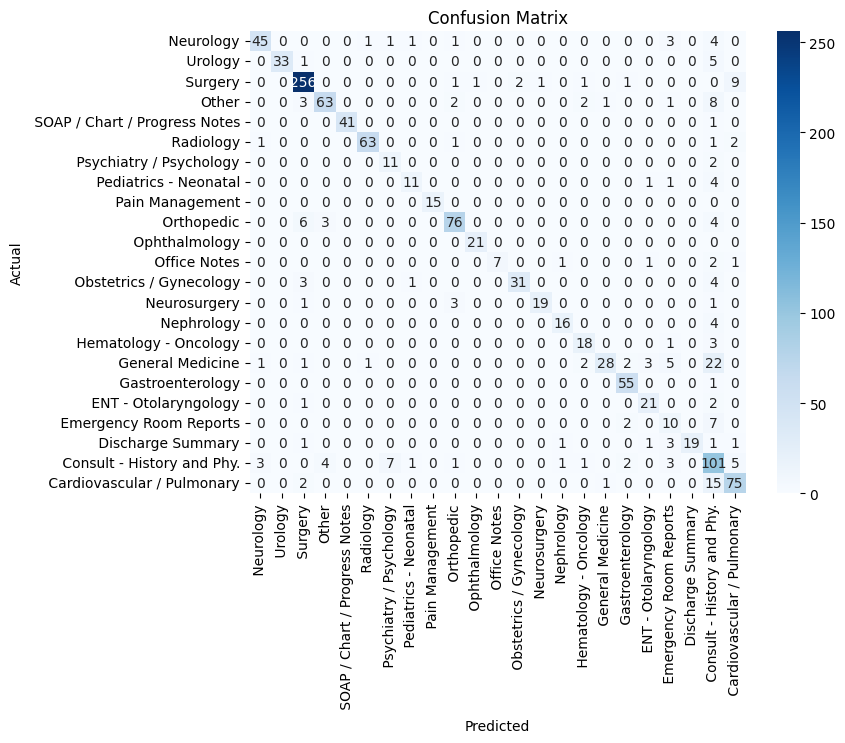

acc----> 0.8053735046596792
f1----> 0.8366151196385976
results---> [ 2  2 21 ... 19 17  9]


In [8]:
acc,f1, result = learningRateExperimenting(1e-4)
print("acc---->",acc)
print("f1---->",f1)
print("results--->",result)

In [5]:
from sklearn.metrics import confusion_matrix